# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections

warnings.filterwarnings('ignore')



In [2]:
from matplotlib.colors import LinearSegmentedColormap


In [3]:
from functools import reduce

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [5]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [6]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../../data_out/'


In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

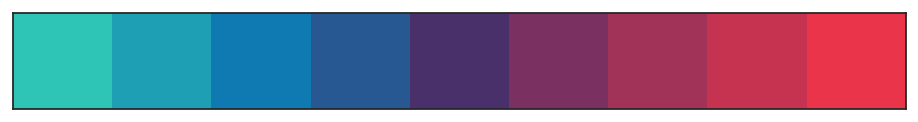

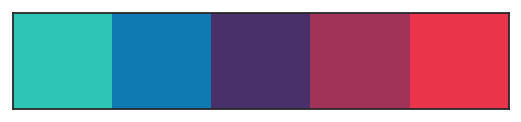

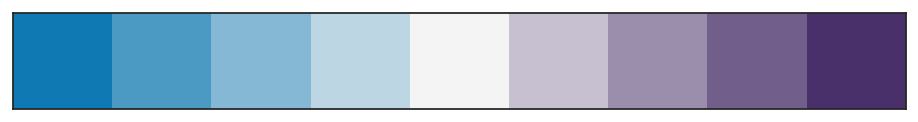

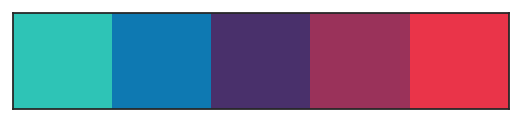

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [10]:
df_all = pd.read_csv(DATA_OUT_PATH + "merged_data.csv")
df_all.tail(3)

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
490,2022-05-06,0.783359,0.798315,0.765742,0.791065,1.312284e+09,17.674110,17.950396,17.255348,17.853285,...,-3.001059,6.211633,6.607955e+10,33.291713,-0.103803,0.085612,4.706712e+10,36.075226,-5.425719,6.790744
491,2022-05-07,0.761882,0.785116,0.750657,0.783352,8.015589e+08,16.475998,17.680393,16.186054,17.676107,...,-4.057486,6.956080,6.546067e+10,32.150293,-0.106420,0.083416,4.592803e+10,34.233934,-5.942282,6.541425
492,2022-05-08,0.744362,0.763704,0.731738,0.761689,1.092425e+09,15.785578,16.511841,15.677500,16.511841,...,-5.163799,7.129811,6.488418e+10,30.140004,-0.110561,0.081053,4.448050e+10,32.050158,-6.554246,6.349738


In [11]:
df_all['Date'].min()

'2021-01-01'

In [12]:
df_all['Date'].max()

'2022-05-08'

## Time Series Analysis

In [13]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as smd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.stats.outliers_influence as oi


In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [15]:
def shift_data(df_, target_col):
    df = df_.copy()

    ## Date_Y is the date being predicted
    ## The corresponding Date_X of the same row is the previous date
    df['Date_Y'] = df['Date']+ pd.DateOffset(days=1) 
    df['Y'] = df[target_col].shift(periods=-1)
    df.rename(columns={'Date':'Date_X'}, inplace=True)
        
    return df
    
    

In [16]:
df_all['Date'] = pd.to_datetime(df_all['Date'])

In [17]:
ada_close = shift_data(df_all, 'ada_close')

In [18]:
endog = ada_close[:-1] #.set_index('Date_Y')
exog_cols = endog.columns.tolist()[1:65]

In [19]:
START_DATE = endog['Date_Y'].min().strftime('%Y-%m-%d')
END_DATE   = endog['Date_Y'].max().strftime('%Y-%m-%d')


In [20]:
coins = ['ada_close',
 'atom_close',
 'avax_close',
 'axs_close',
 'btc_close',
 'eth_close',
 'link_close',
 'luna1_close',
 'matic_close',
 'sol_close']

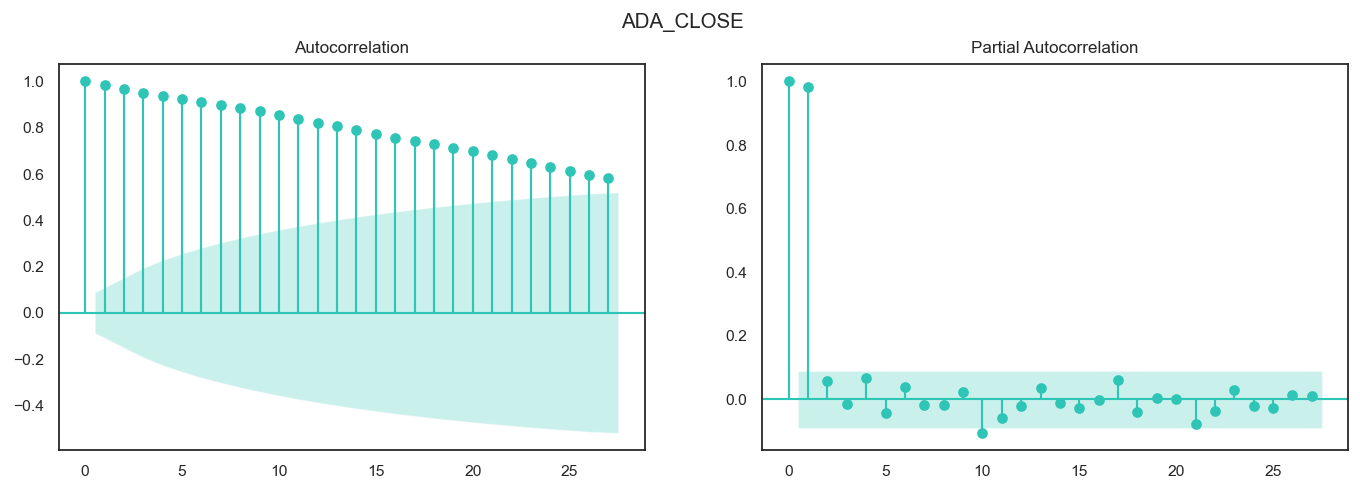

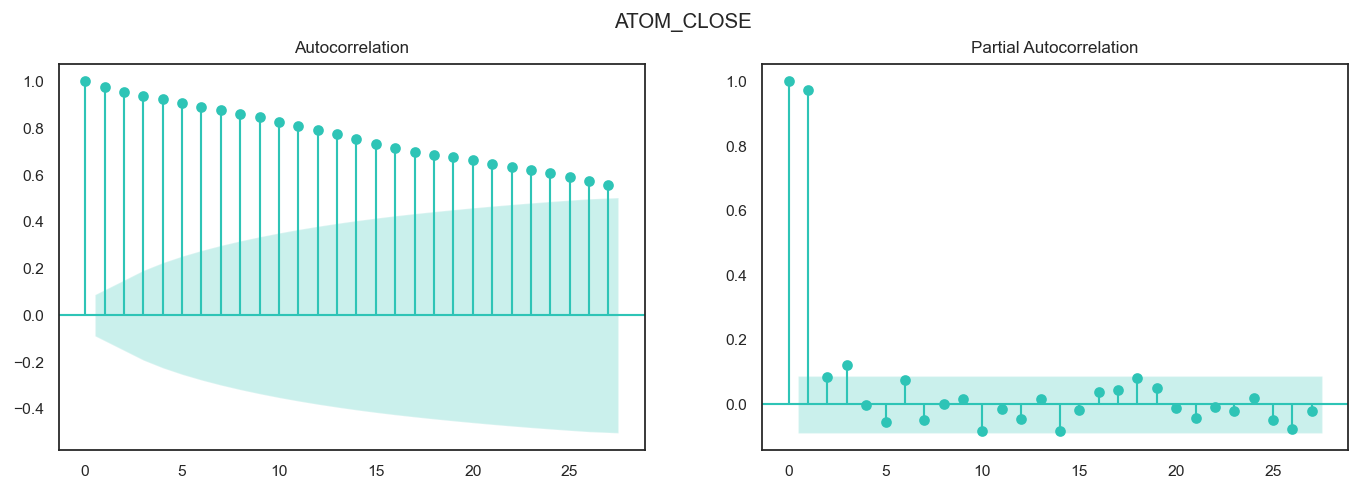

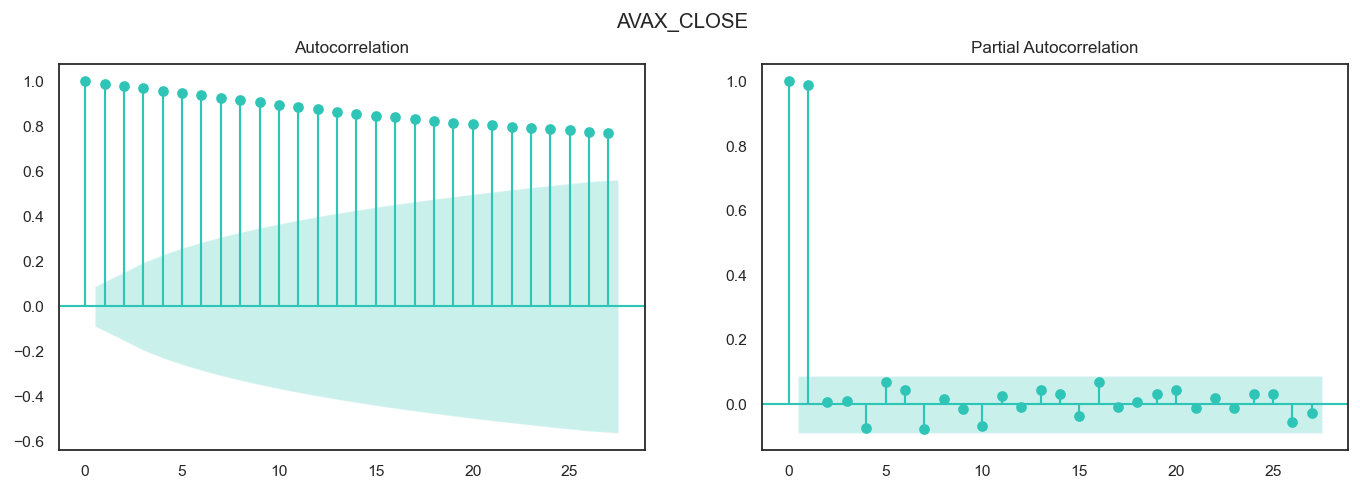

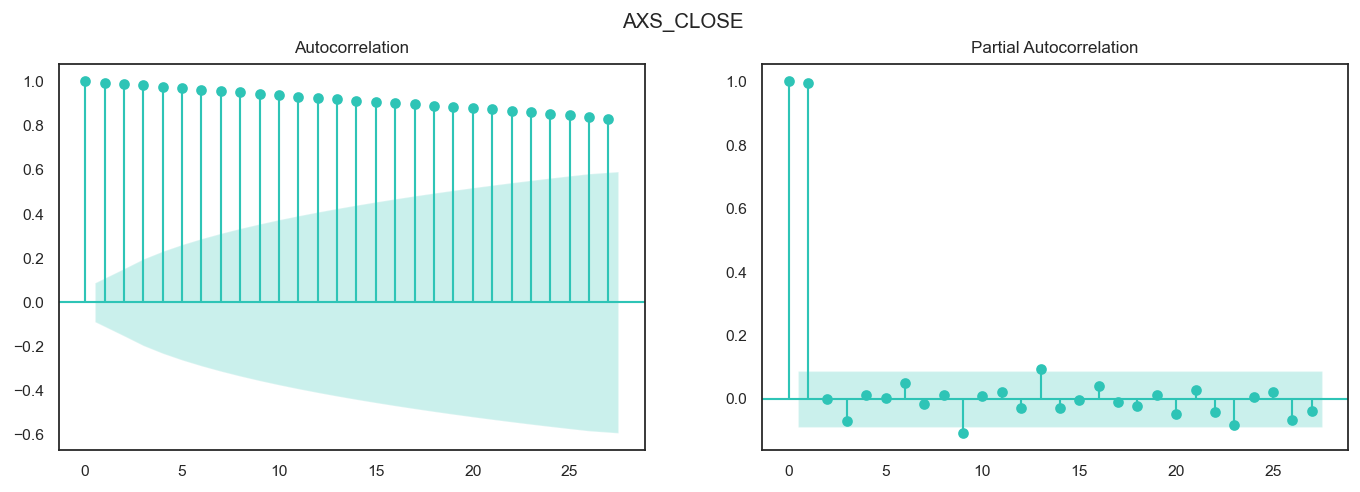

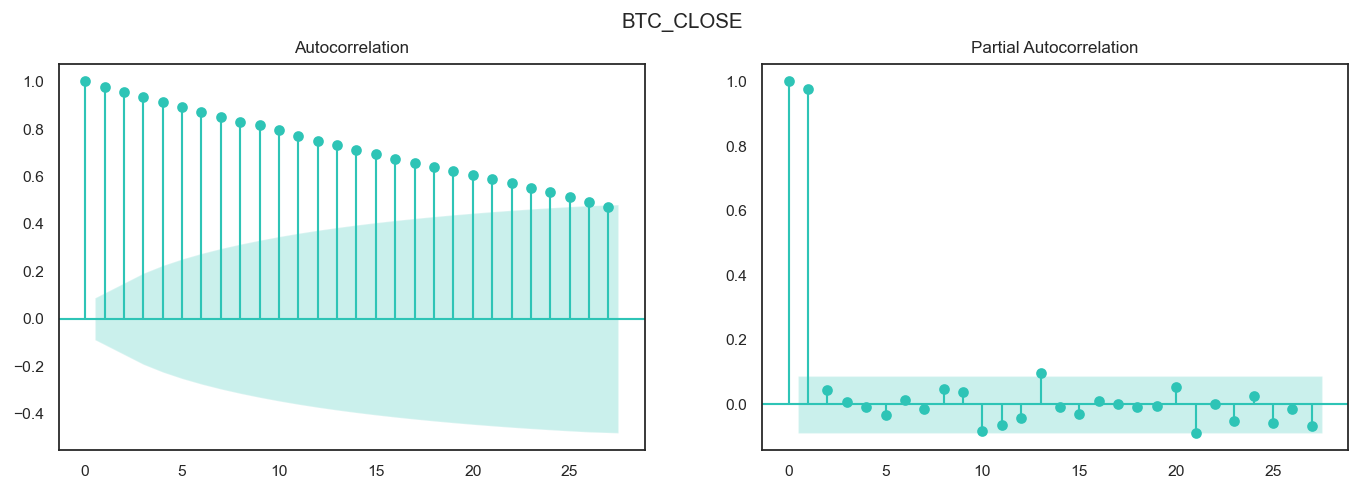

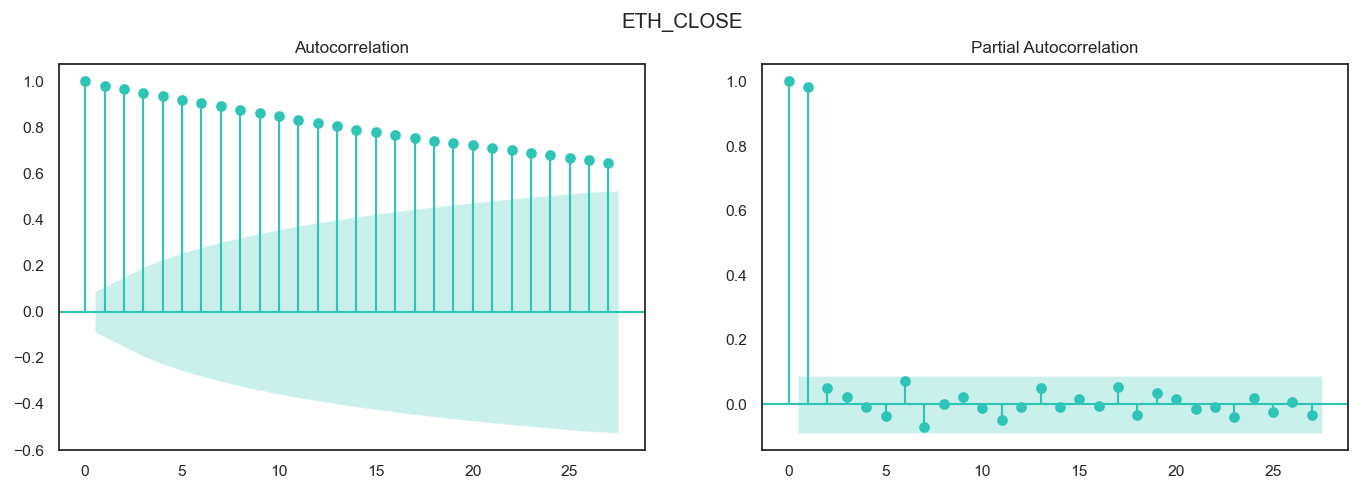

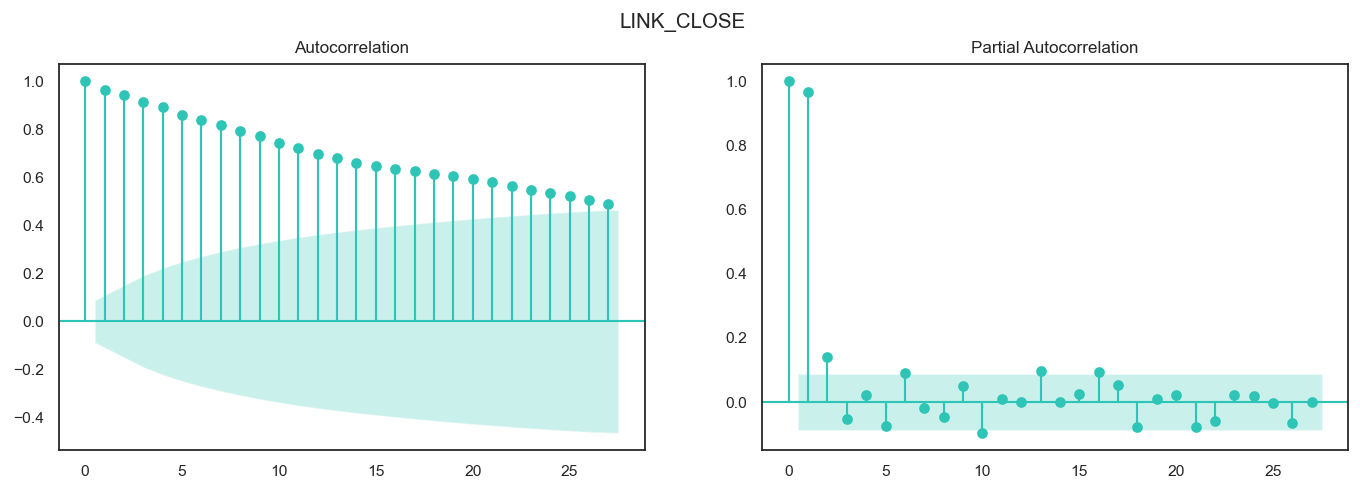

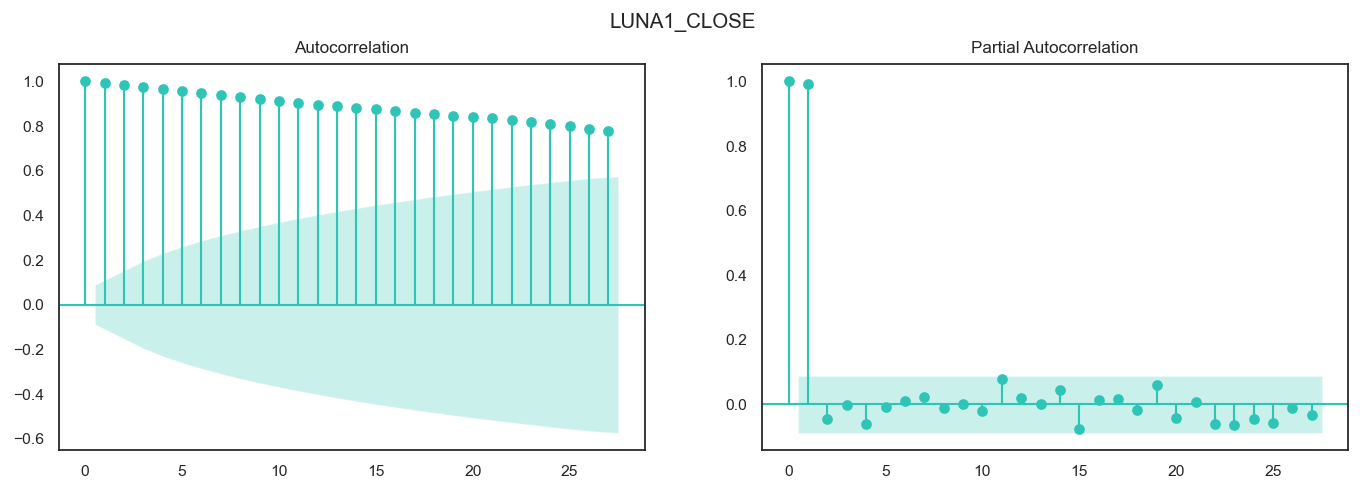

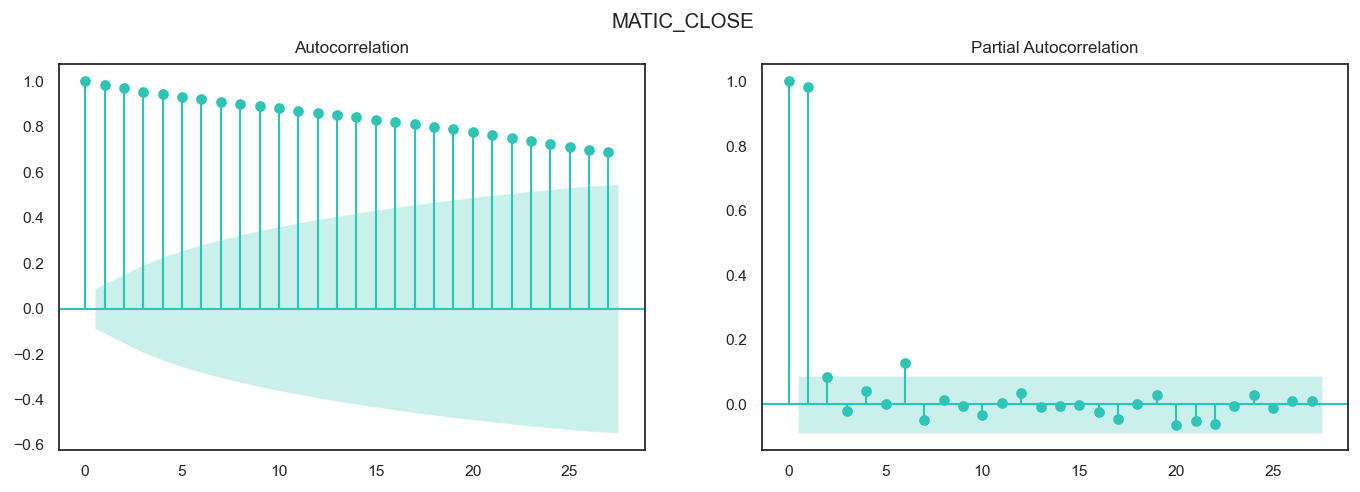

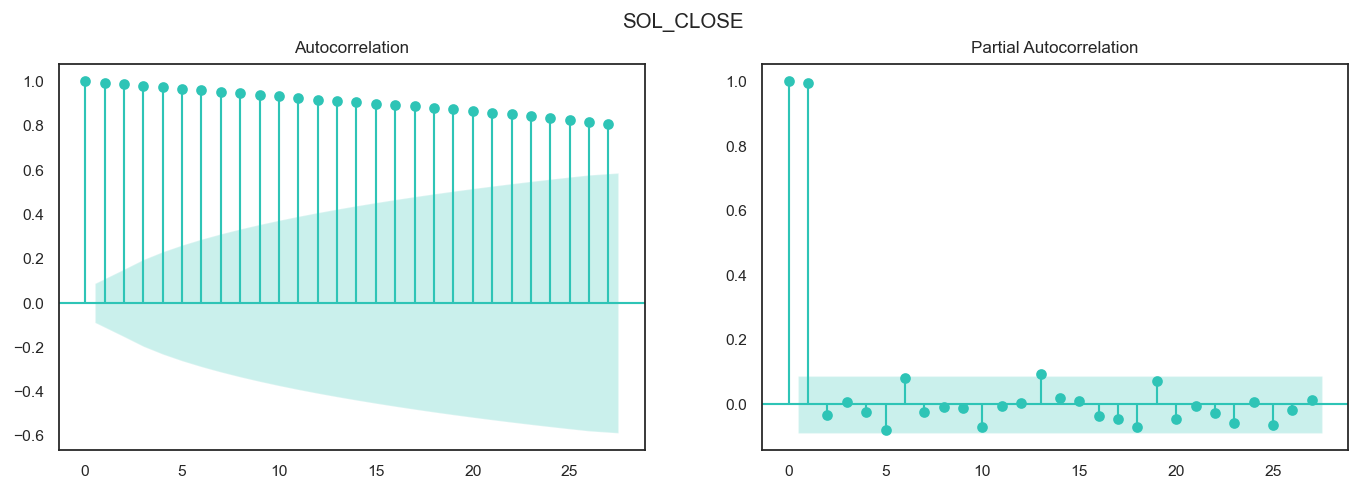

In [21]:
for df_i in range(len(coins)):
    
    hi = coins[df_i]
    
    endog_ = endog.copy()[[hi]] 
    endog_.index = pd.period_range(START_DATE,END_DATE,freq='D')

    fig, axes = plt.subplots(1,2,figsize=(13,4))

    sm.graphics.tsa.plot_acf(endog_, ax=axes[0])
    sm.graphics.tsa.plot_pacf(endog_, method="ywm", ax=axes[1])

    fig.suptitle(str.upper(coins[df_i]))
    plt.show()
    


In [22]:
endog_ = endog.copy()[[coins[0]]] 
endog_

,ada_close
0,0.175350
1,0.177423
2,0.204995
3,0.224762
4,0.258314
...,...
487,0.771145
488,0.896942
489,0.791152
490,0.783359


*********************************************************************************************
********************************** ada_close **********************************
2021-01-02 2022-05-08


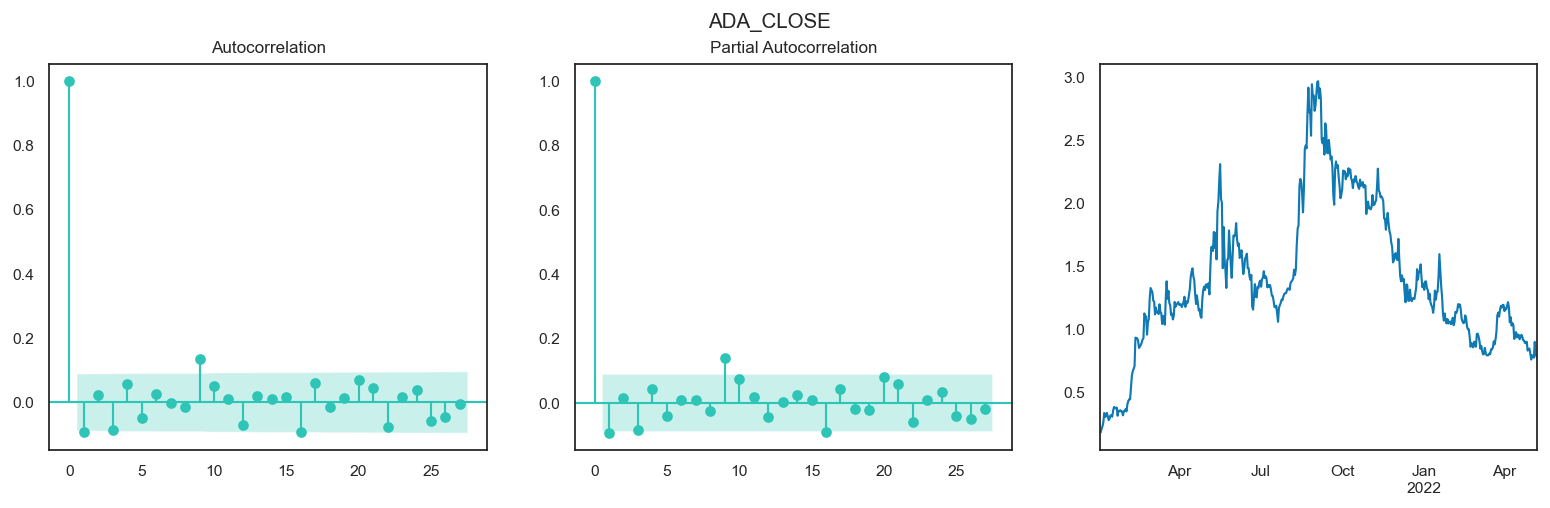

Optimization terminated successfully.
         Current function value: -0.966436
         Iterations: 4
         Function evaluations: 174
                               SARIMAX Results                                
Dep. Variable:              ada_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 434.896
Date:                Mon, 09 May 2022   AIC                           -863.792
Time:                        21:34:18   BIC                           -851.464
Sample:                    01-02-2021   HQIC                          -858.933
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.024      0.306      -0.011     

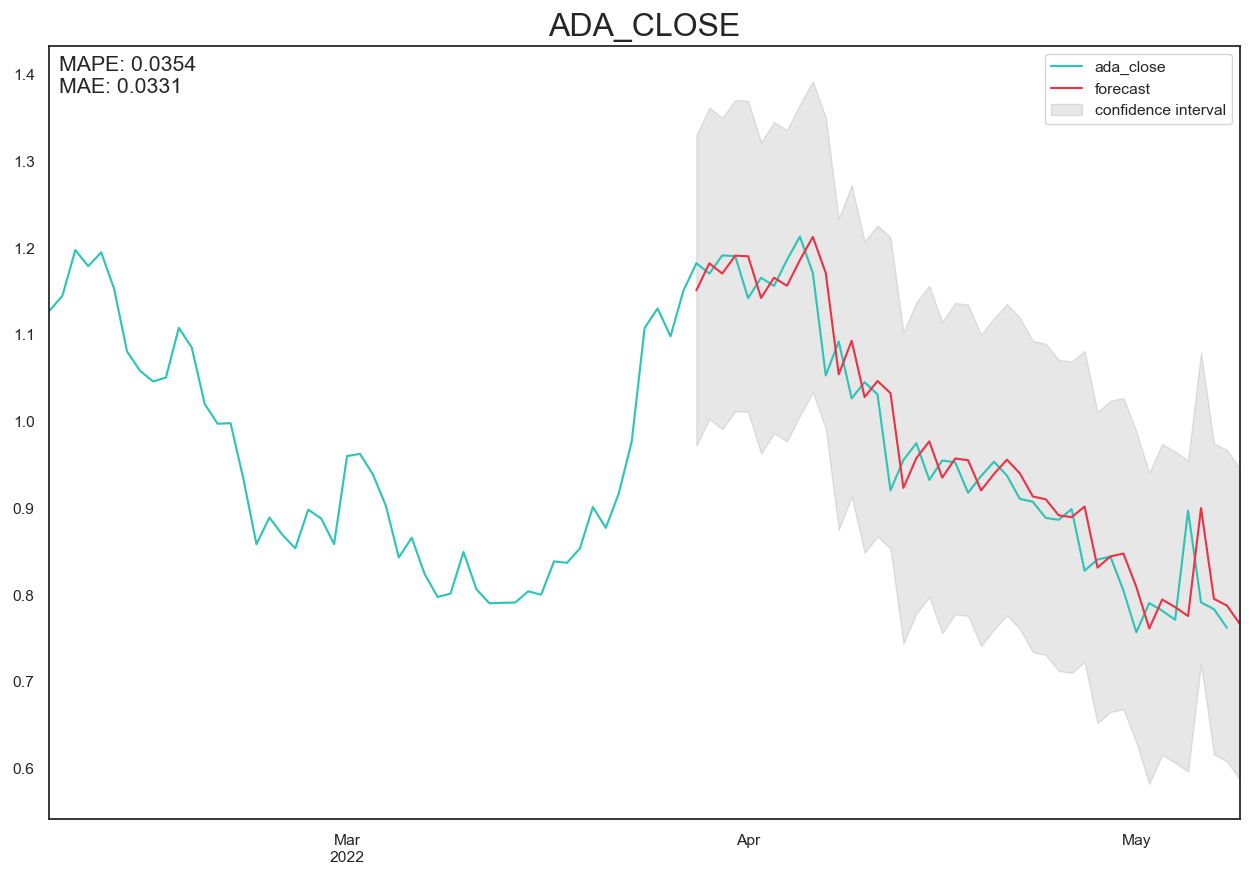

*********************************************************************************************
********************************** atom_close **********************************
2021-01-02 2022-05-08


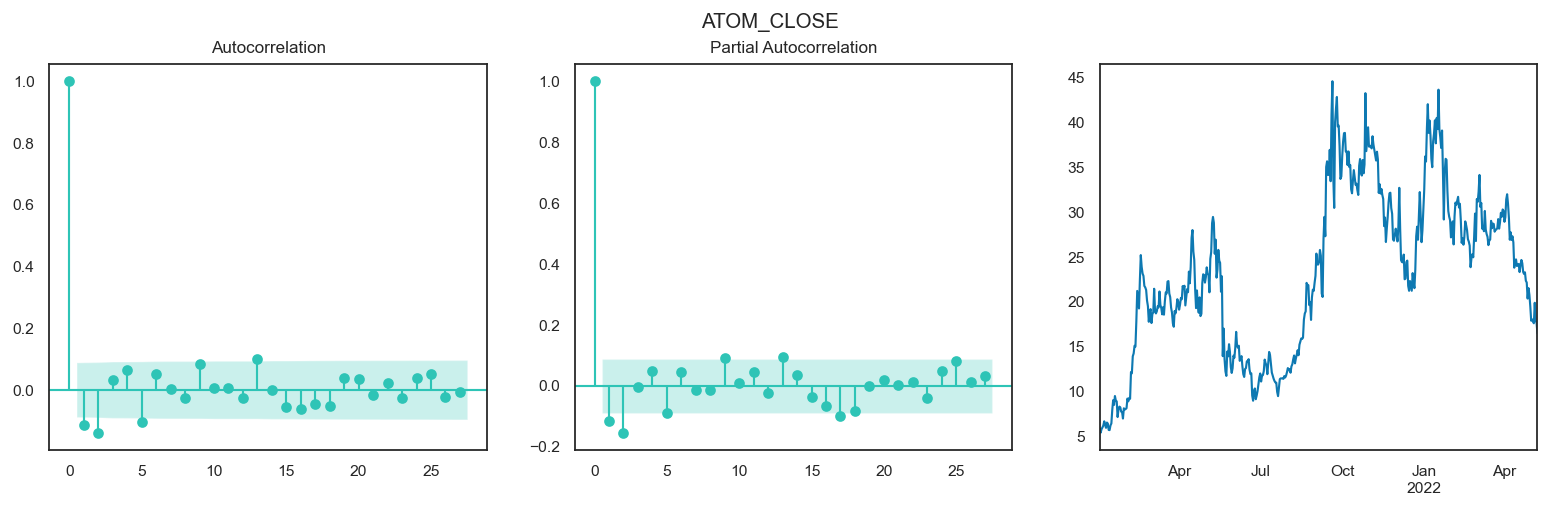

Optimization terminated successfully.
         Current function value: 2.081813
         Iterations: 2
         Function evaluations: 77
                               SARIMAX Results                                
Dep. Variable:             atom_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -936.816
Date:                Mon, 09 May 2022   AIC                           1879.632
Time:                        21:34:18   BIC                           1891.960
Sample:                    01-02-2021   HQIC                          1884.491
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4967      0.252      1.973      0.049       0.003       

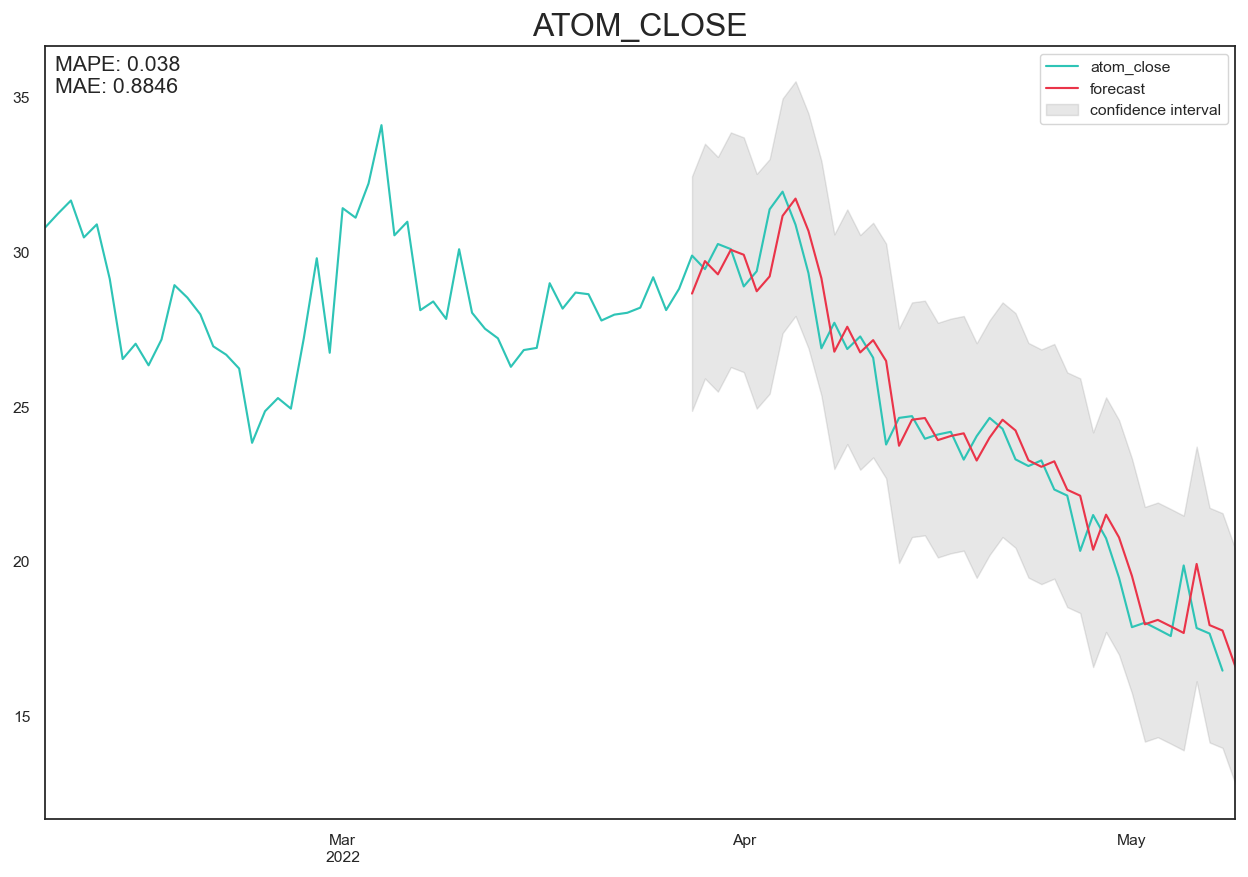

*********************************************************************************************
********************************** avax_close **********************************
2021-01-02 2022-05-08


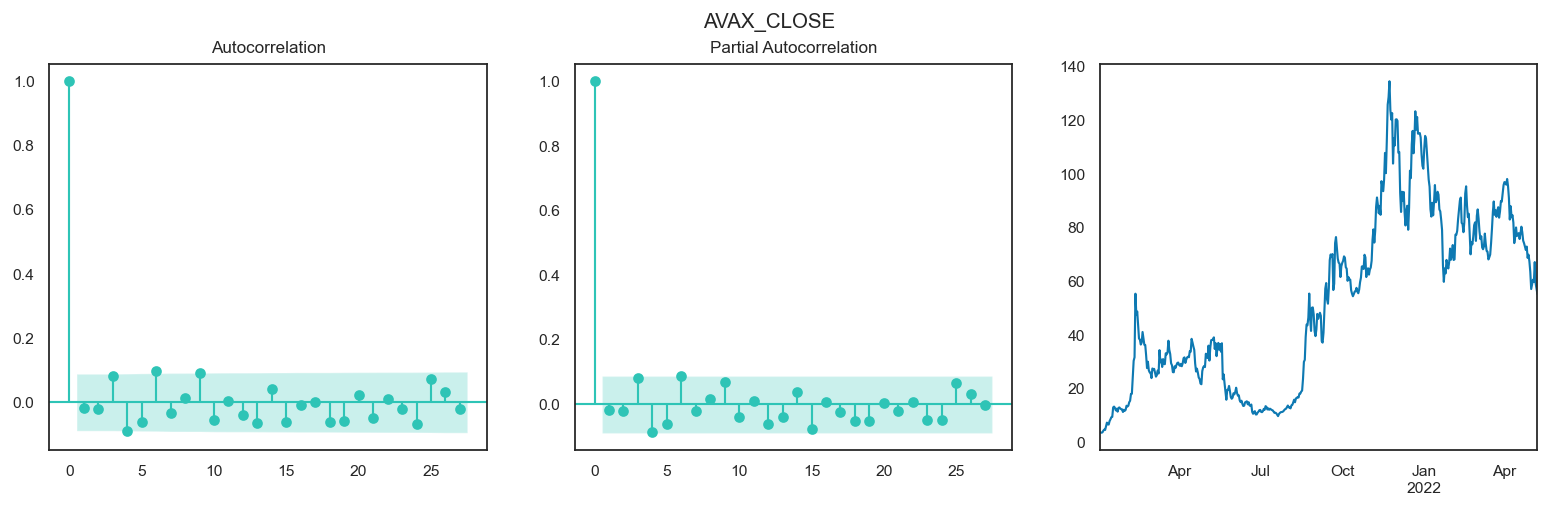

Optimization terminated successfully.
         Current function value: 2.883985
         Iterations: 2
         Function evaluations: 73
                               SARIMAX Results                                
Dep. Variable:             avax_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1297.793
Date:                Mon, 09 May 2022   AIC                           2601.587
Time:                        21:34:19   BIC                           2613.915
Sample:                    01-02-2021   HQIC                          2606.446
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3952      0.301      1.313      0.189      -0.195       

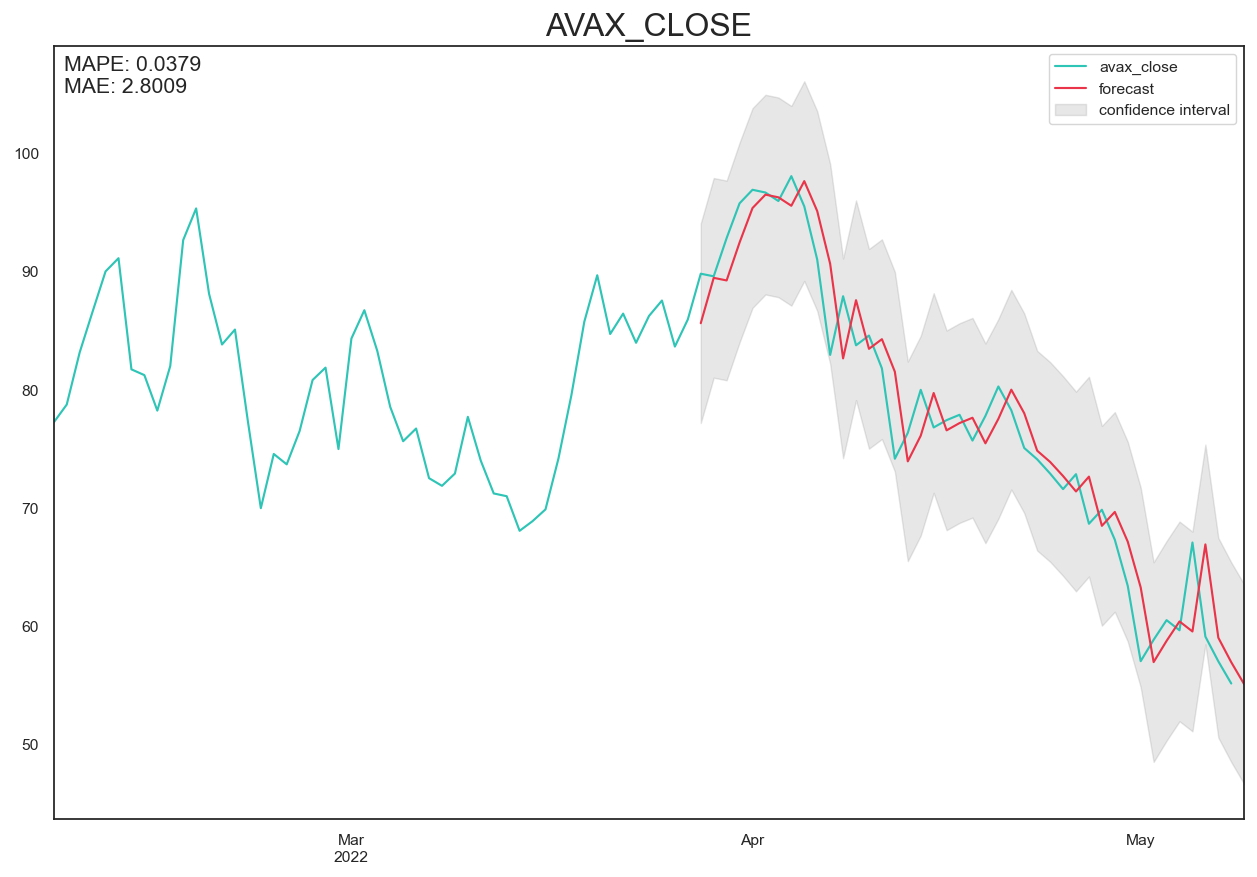

*********************************************************************************************
********************************** axs_close **********************************
2021-01-02 2022-05-08


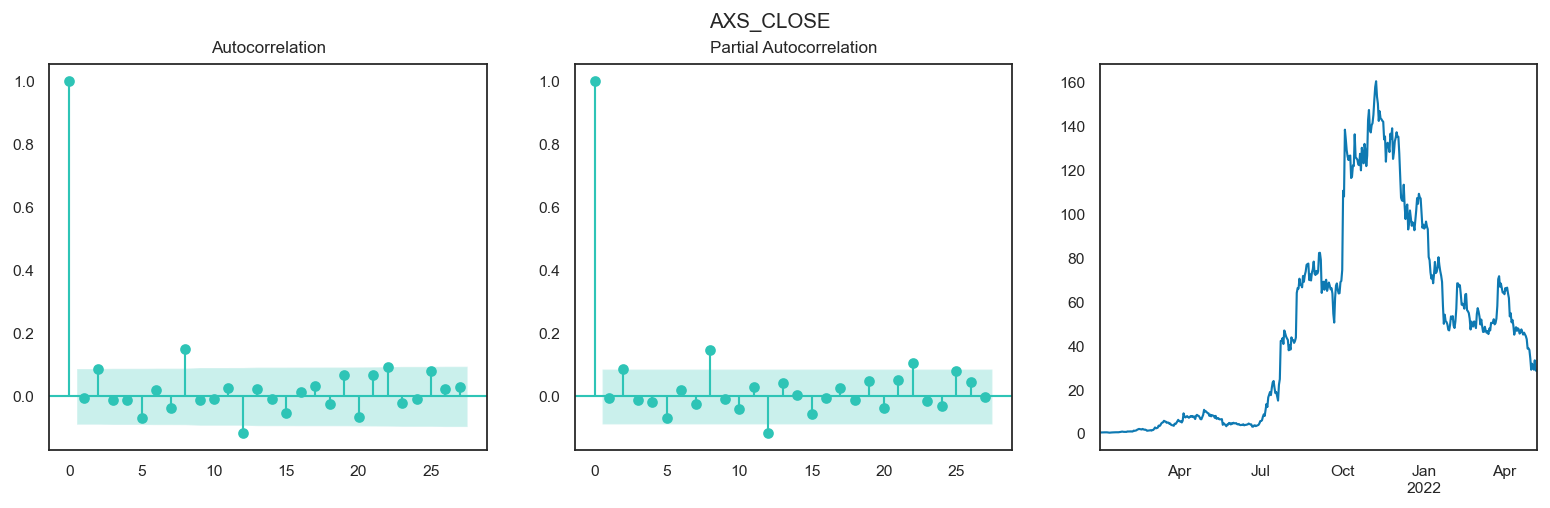

Optimization terminated successfully.
         Current function value: 2.895316
         Iterations: 2
         Function evaluations: 75
                               SARIMAX Results                                
Dep. Variable:              axs_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1302.892
Date:                Mon, 09 May 2022   AIC                           2611.785
Time:                        21:34:20   BIC                           2624.113
Sample:                    01-02-2021   HQIC                          2616.644
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2140      0.152      1.405      0.160      -0.084       

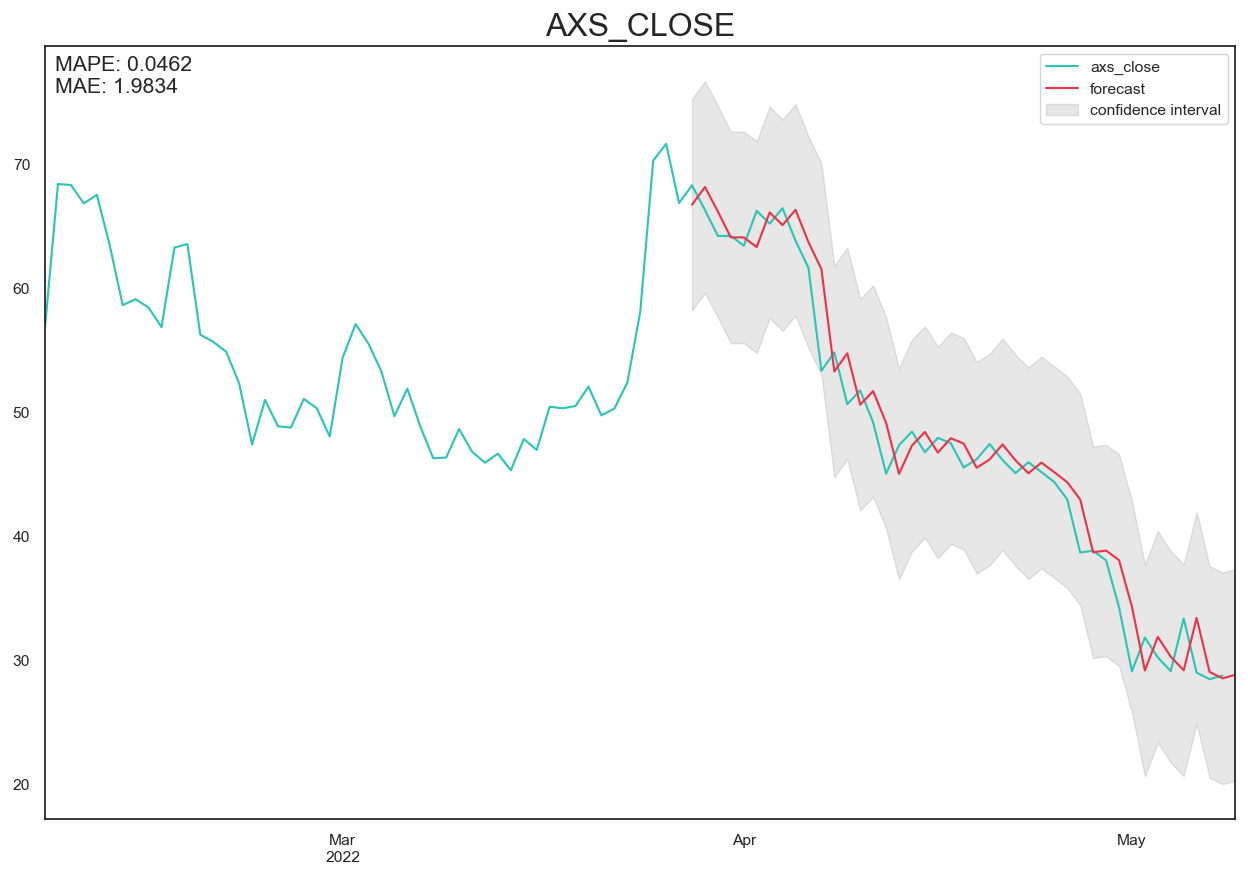

*********************************************************************************************
********************************** btc_close **********************************
2021-01-02 2022-05-08


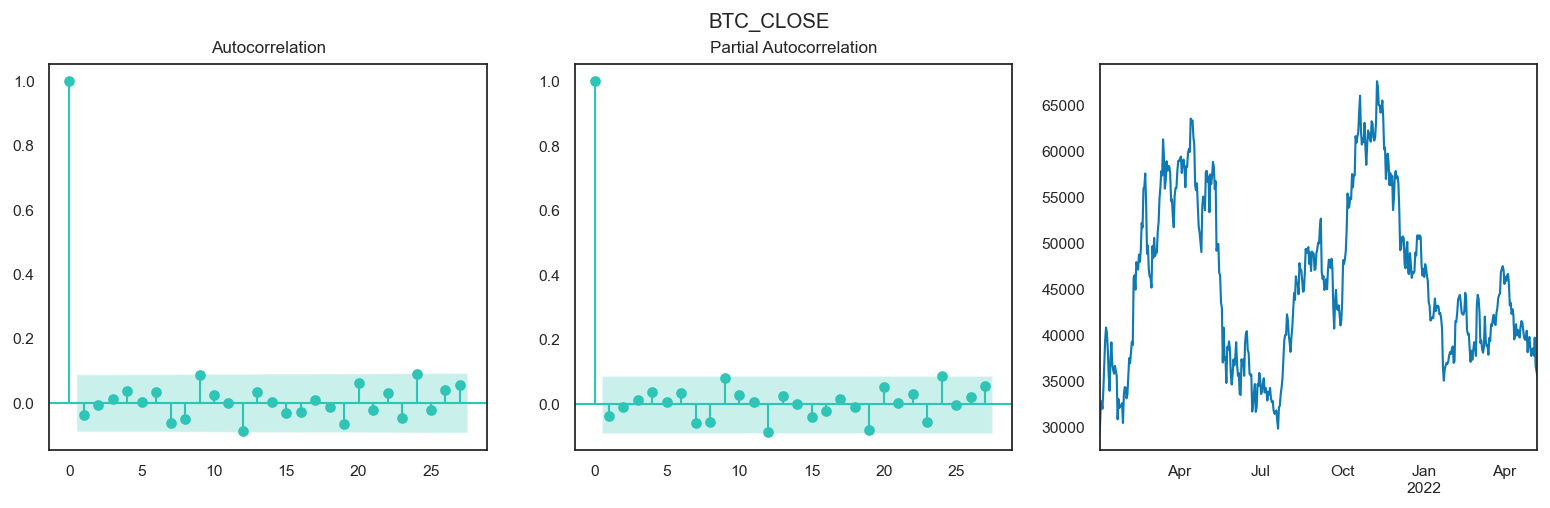

Optimization terminated successfully.
         Current function value: 8.928641
         Iterations: 1
         Function evaluations: 32
                               SARIMAX Results                                
Dep. Variable:              btc_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4017.888
Date:                Mon, 09 May 2022   AIC                           8041.776
Time:                        21:34:20   BIC                           8054.104
Sample:                    01-02-2021   HQIC                          8046.635
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1036.3527    478.482      2.166      0.030      98.545    197

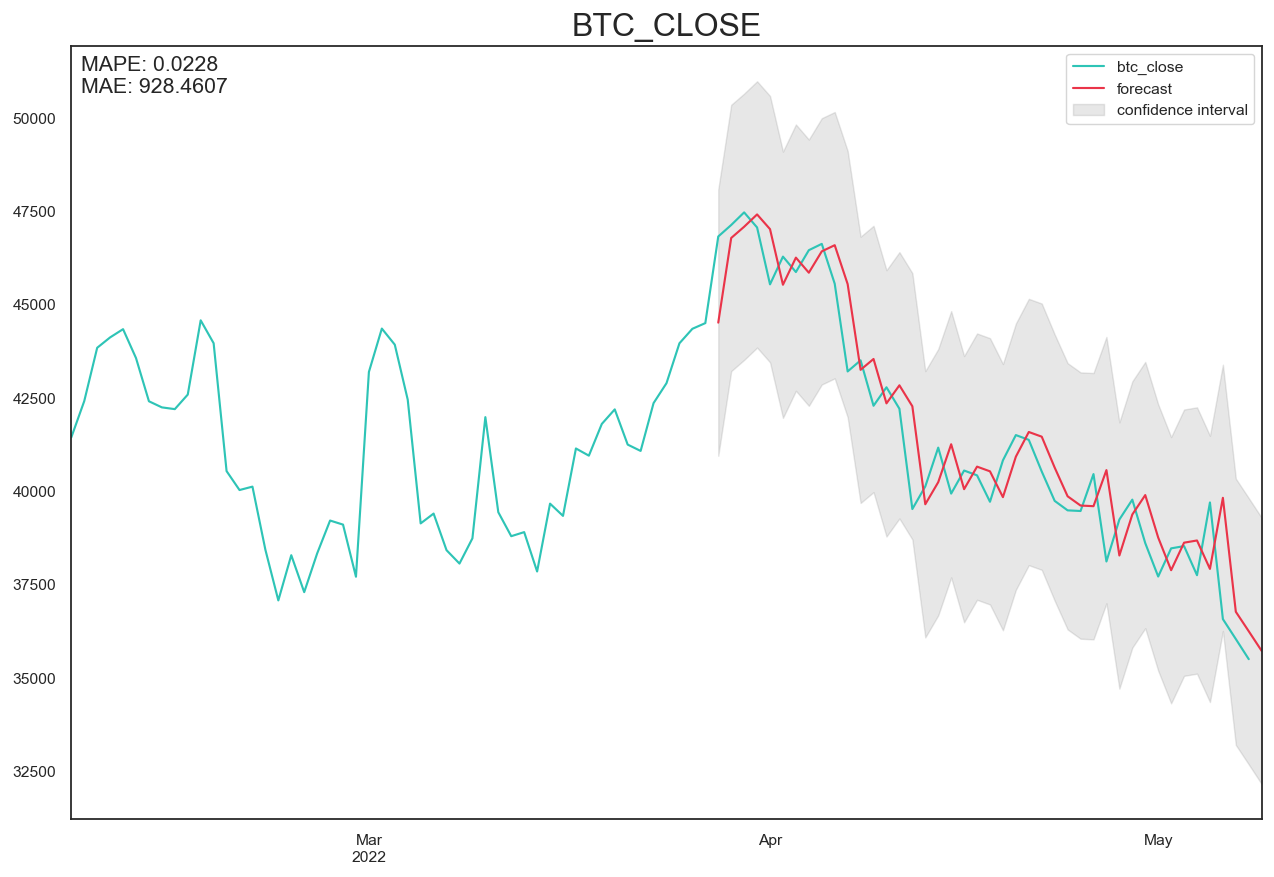

*********************************************************************************************
********************************** eth_close **********************************
2021-01-02 2022-05-08


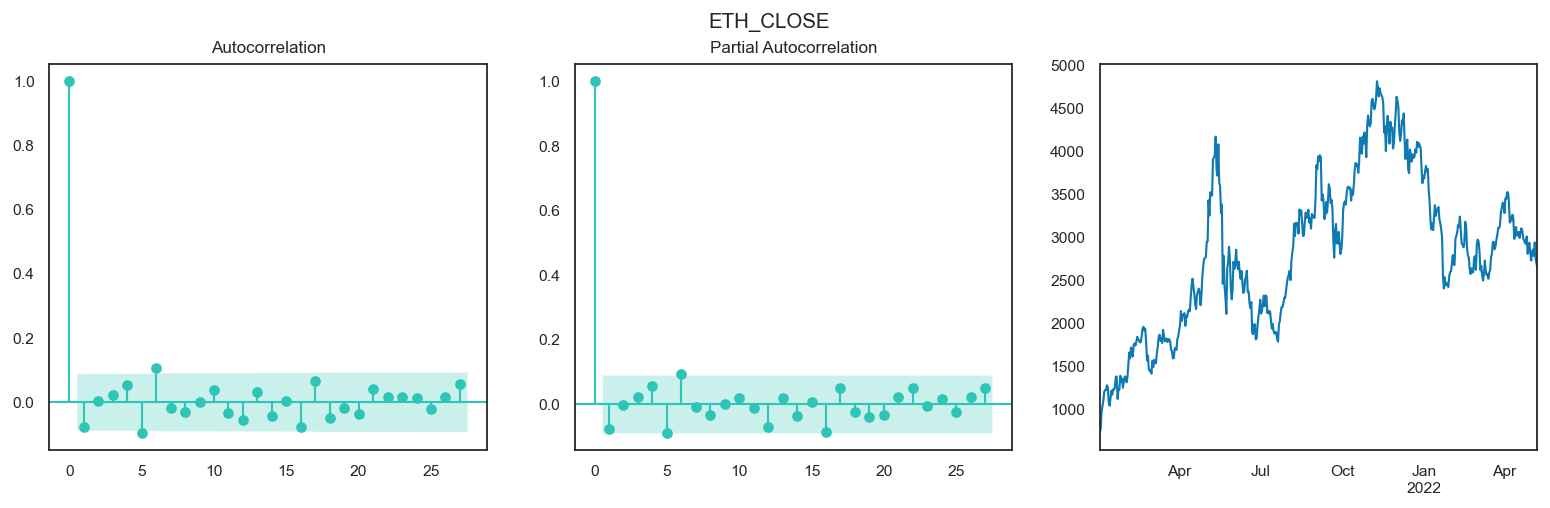

Optimization terminated successfully.
         Current function value: 6.393899
         Iterations: 2
         Function evaluations: 69
                               SARIMAX Results                                
Dep. Variable:              eth_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2877.254
Date:                Mon, 09 May 2022   AIC                           5760.509
Time:                        21:34:21   BIC                           5772.836
Sample:                    01-02-2021   HQIC                          5765.368
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.3110     31.209      1.260      0.208     -21.858     10

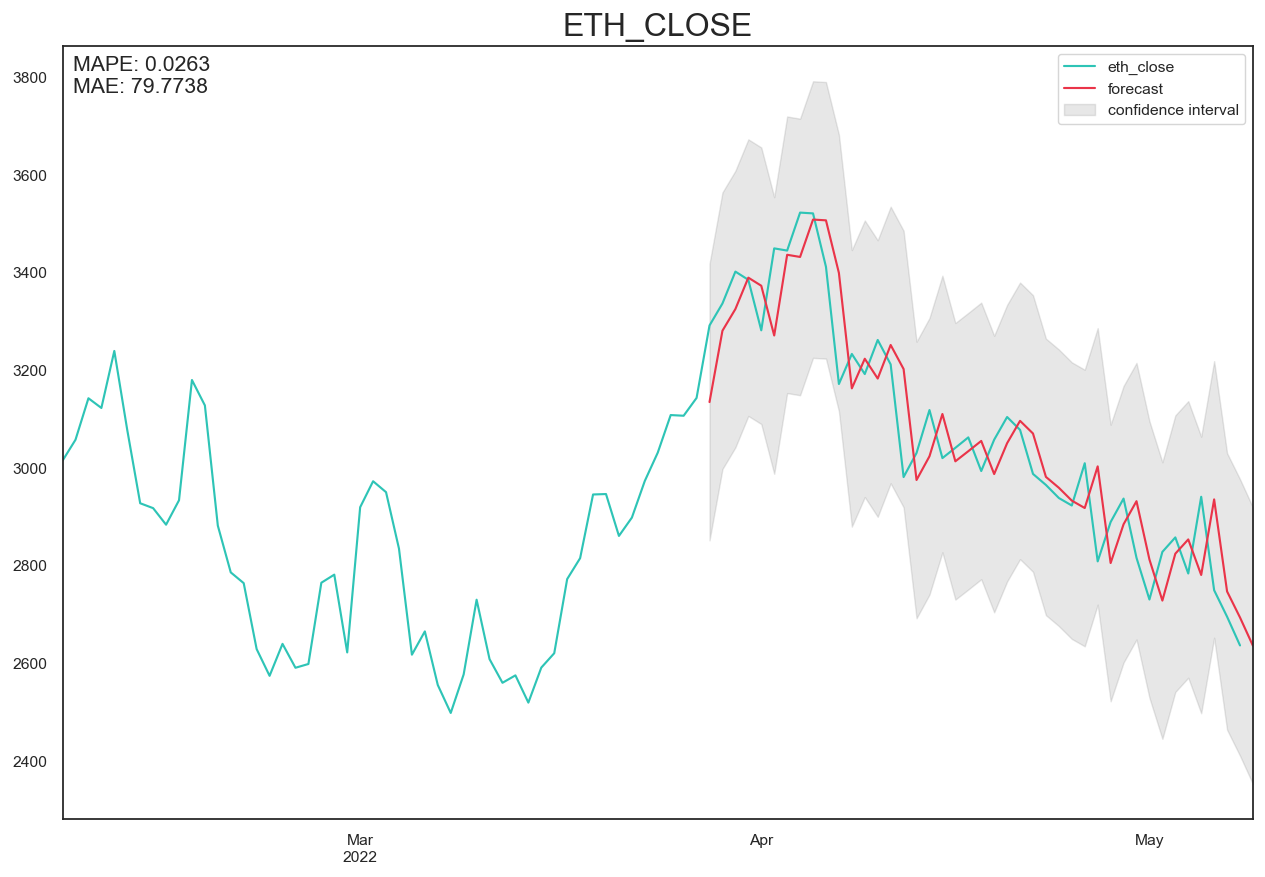

*********************************************************************************************
********************************** link_close **********************************
2021-01-02 2022-05-08


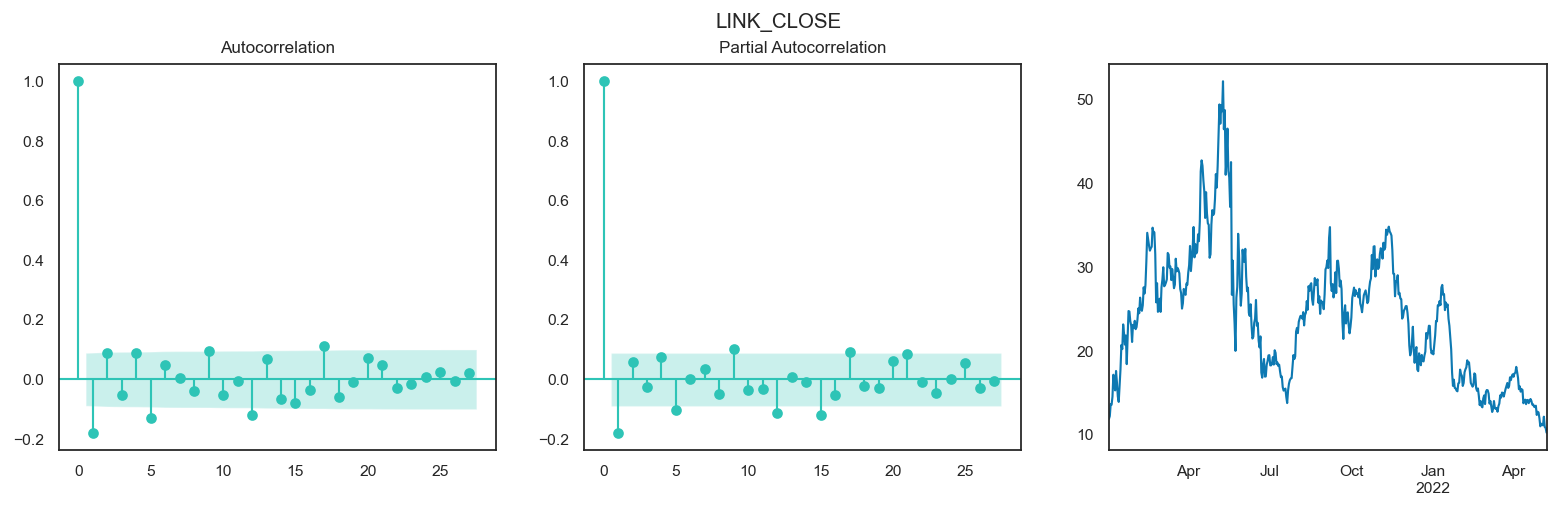

Optimization terminated successfully.
         Current function value: 2.068826
         Iterations: 2
         Function evaluations: 75
                               SARIMAX Results                                
Dep. Variable:             link_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -930.972
Date:                Mon, 09 May 2022   AIC                           1867.943
Time:                        21:34:22   BIC                           1880.271
Sample:                    01-02-2021   HQIC                          1872.802
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8015      0.424      1.892      0.058      -0.029       

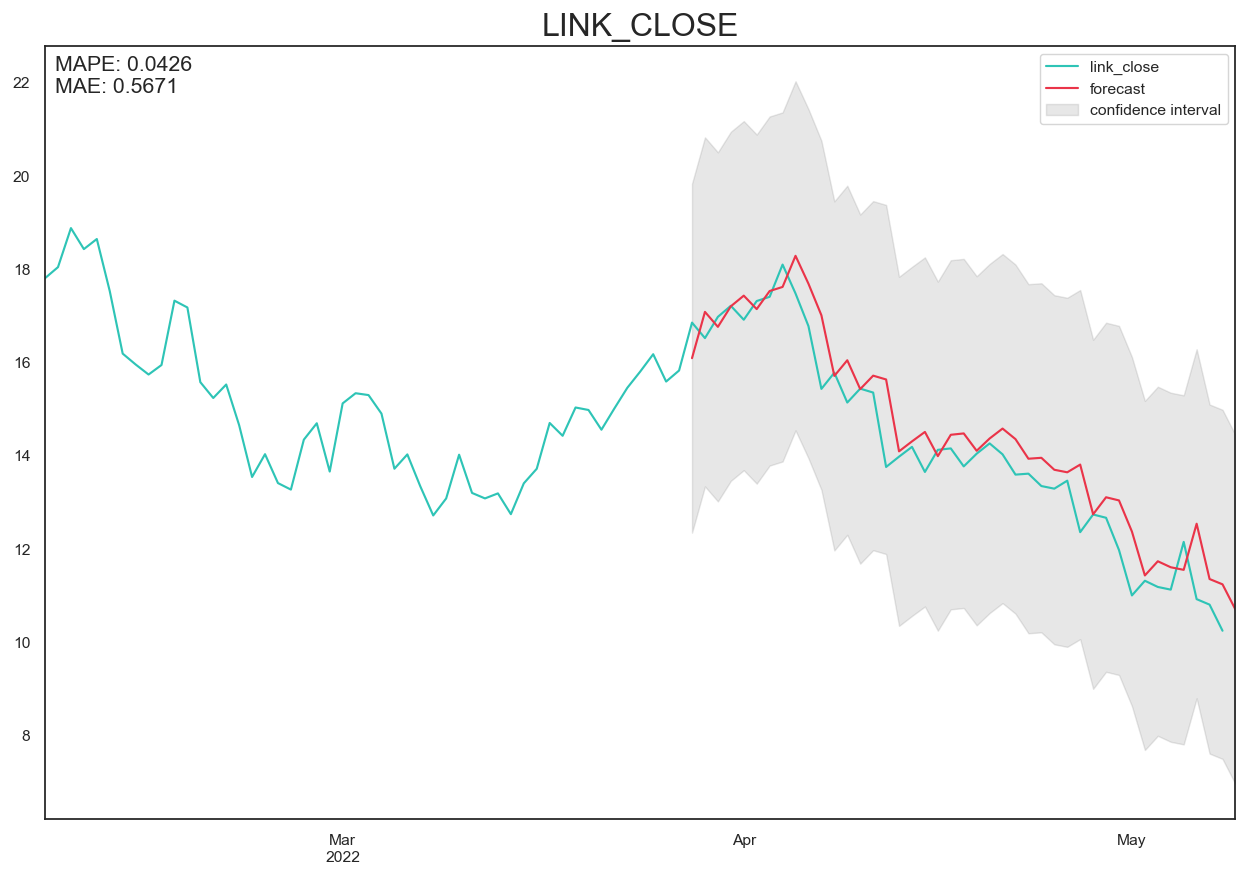

*********************************************************************************************
********************************** luna1_close **********************************
2021-01-02 2022-05-08


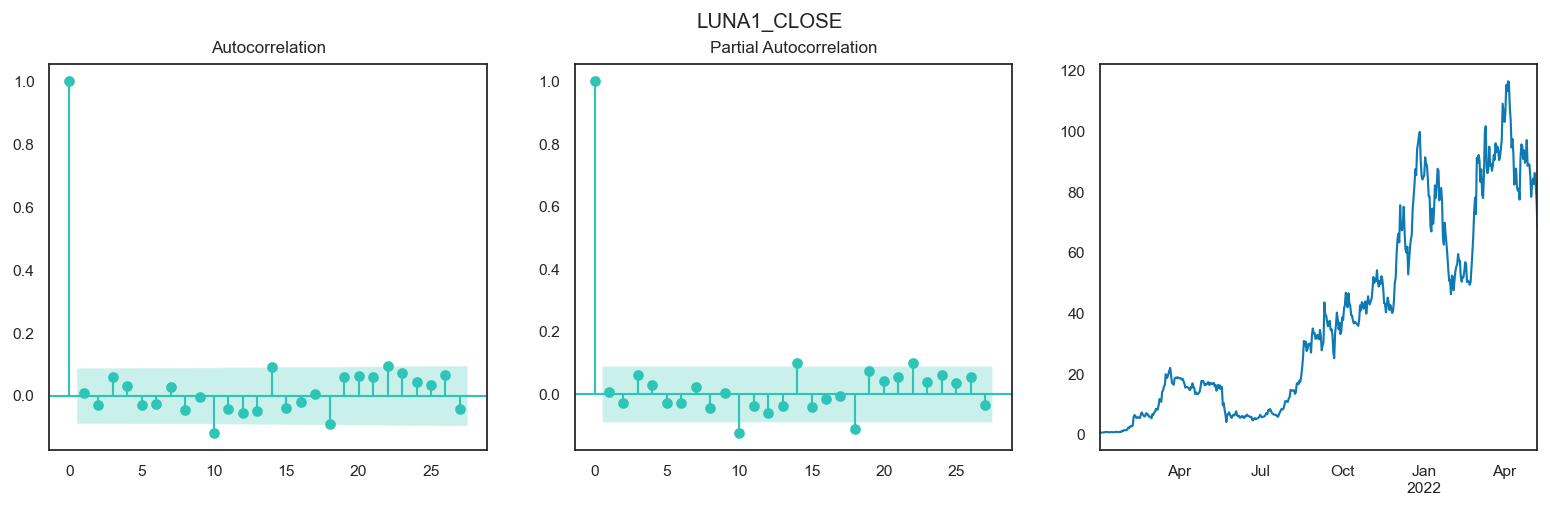

Optimization terminated successfully.
         Current function value: 2.560384
         Iterations: 2
         Function evaluations: 63
                               SARIMAX Results                                
Dep. Variable:            luna1_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1152.173
Date:                Mon, 09 May 2022   AIC                           2310.346
Time:                        21:34:22   BIC                           2322.673
Sample:                    01-02-2021   HQIC                          2315.204
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1250      0.093      1.338      0.181      -0.058       

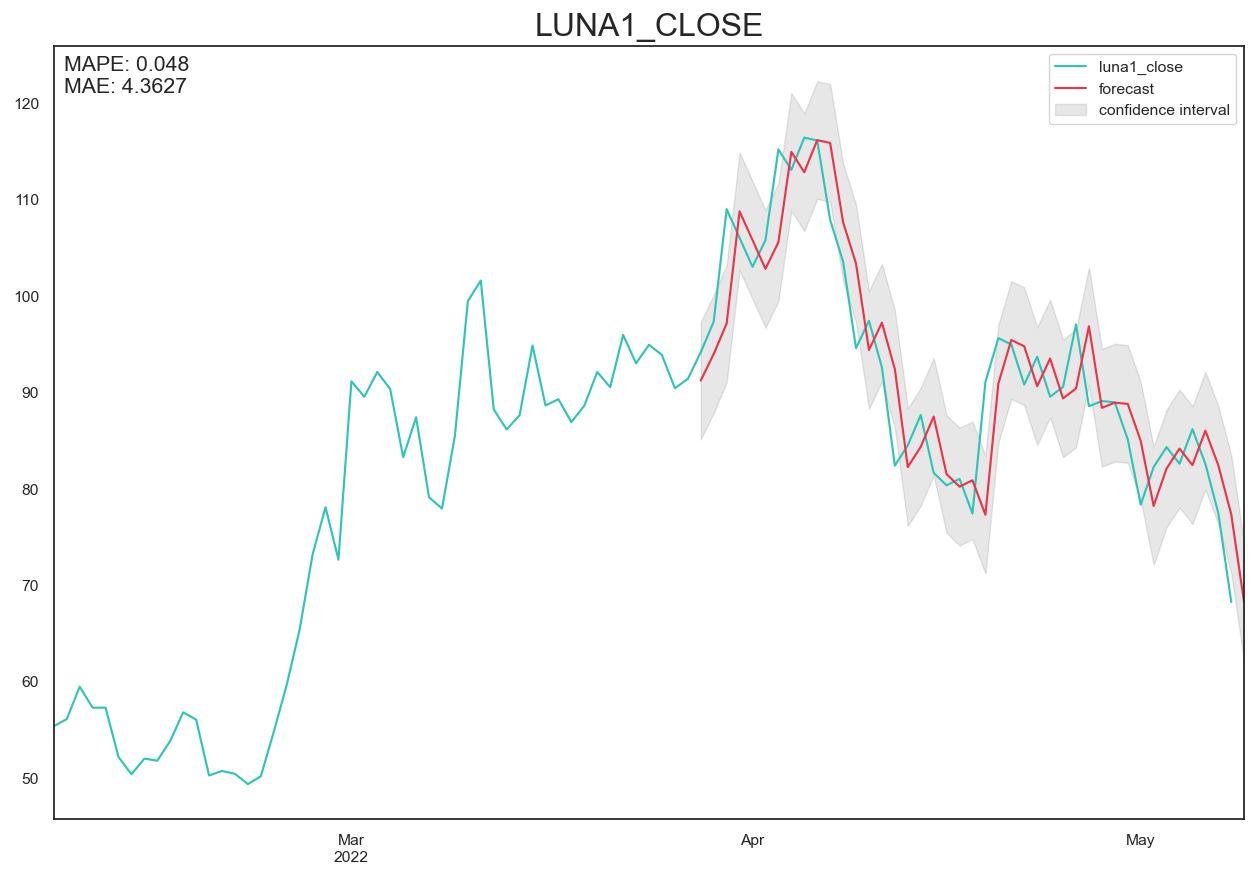

*********************************************************************************************
********************************** matic_close **********************************
2021-01-02 2022-05-08


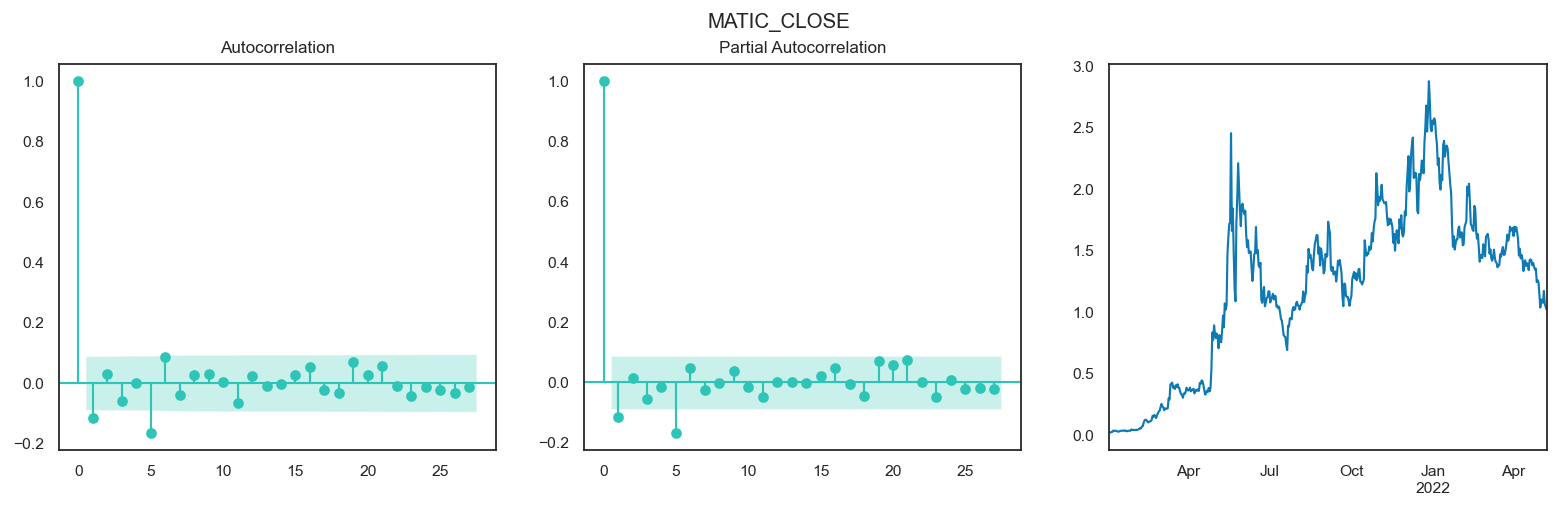

Optimization terminated successfully.
         Current function value: -0.755309
         Iterations: 3
         Function evaluations: 122
                               SARIMAX Results                                
Dep. Variable:            matic_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 339.889
Date:                Mon, 09 May 2022   AIC                           -673.778
Time:                        21:34:23   BIC                           -661.451
Sample:                    01-02-2021   HQIC                          -668.920
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0146      0.010      1.504      0.132      -0.004     

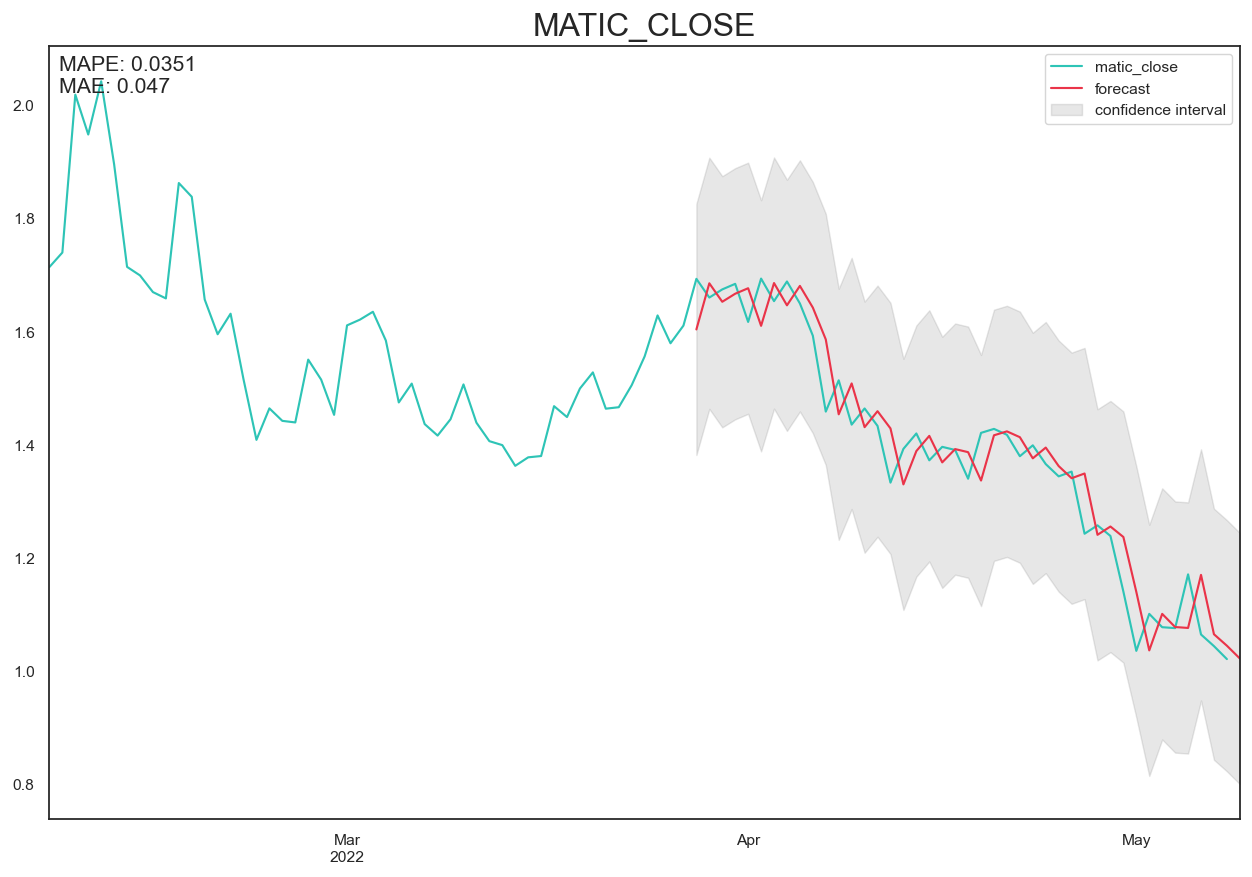

*********************************************************************************************
********************************** sol_close **********************************
2021-01-02 2022-05-08


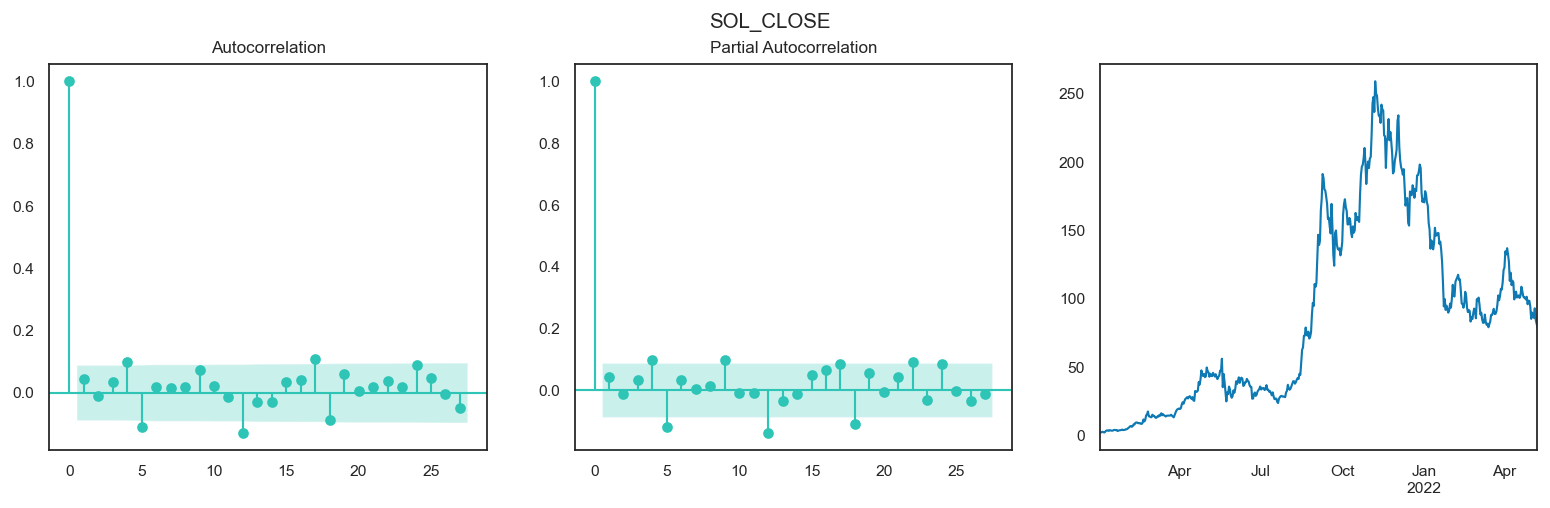

Optimization terminated successfully.
         Current function value: 3.293565
         Iterations: 2
         Function evaluations: 74
                               SARIMAX Results                                
Dep. Variable:              sol_close   No. Observations:                  450
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1482.104
Date:                Mon, 09 May 2022   AIC                           2970.209
Time:                        21:34:24   BIC                           2982.537
Sample:                    01-02-2021   HQIC                          2975.068
                         - 03-27-2022                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3450      0.290      1.190      0.234      -0.223       

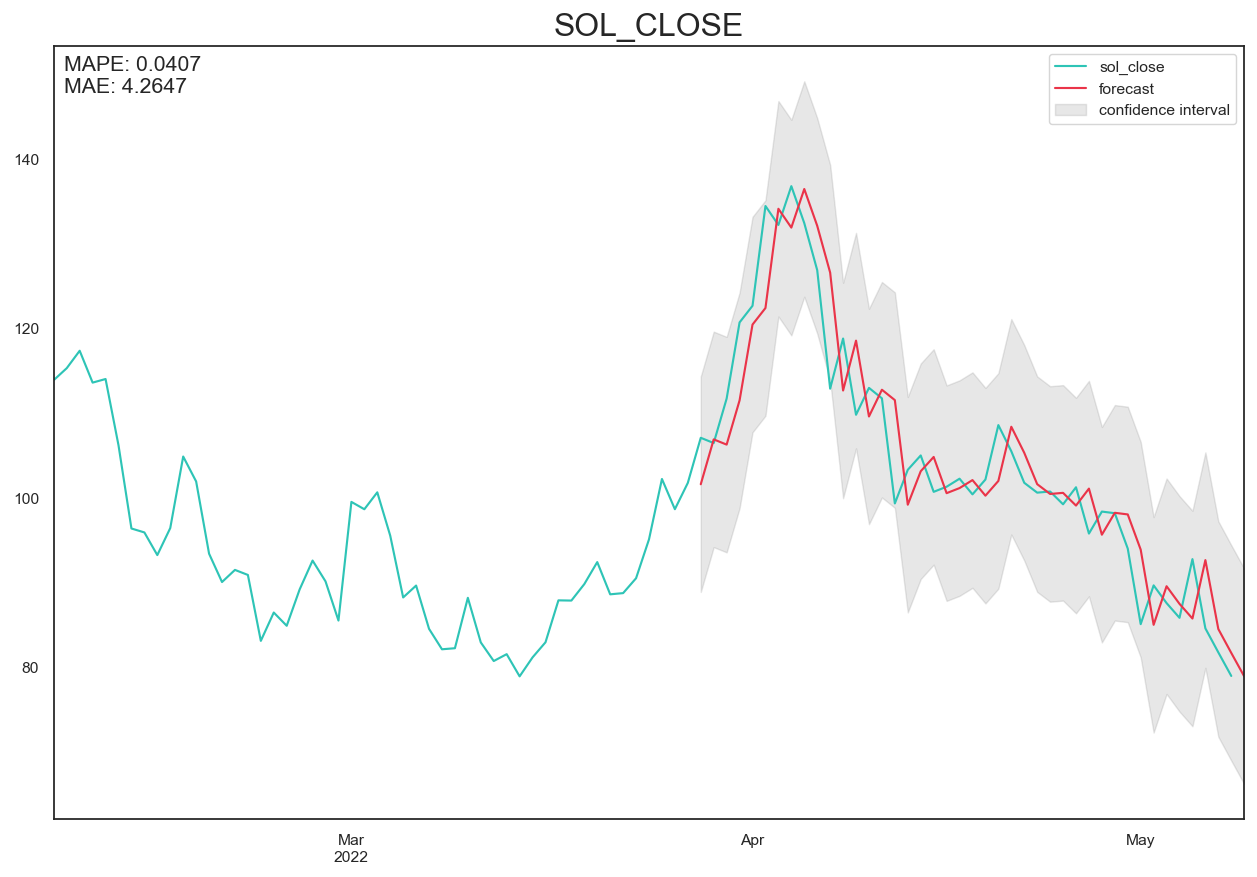

In [23]:
for df_i in range(len(coins)):
    print('*********************************************************************************************')
    print('**********************************', coins[df_i], '**********************************')
    
    
    hi = coins[df_i]
    
    endog_ = endog.copy()[[hi]] 
    endog_.index = pd.period_range(START_DATE,END_DATE,freq='D')

    
    
    
    
    #endog_start = endog_.loc[:,['Date',hi]].dropna()['Date'].min().strftime('%Y-%m-%d')
    #endog_end   = endog_.loc[:,['Date',hi]].dropna()['Date'].max().strftime('%Y-%m-%d')

    print(START_DATE, END_DATE)

    
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    
    endog_.loc[:,[hi]].plot(ax=axes[2], color=CAT_COLORS[1], legend=False)
    
    endog_diff = endog_.copy()
    endog_diff['diff'] = endog_diff[hi].diff()
    endog_diff.dropna(inplace=True)

    sm.graphics.tsa.plot_acf(endog_diff['diff'], ax=axes[0])
    sm.graphics.tsa.plot_pacf(endog_diff['diff'], method="ywm", ax=axes[1])
    
    fig.suptitle(str.upper(coins[df_i]))

    plt.show()
    
    
    
    mod = sm.tsa.SARIMAX(endog_.iloc[:450], order=(1, 0, 0), trend='c', enforce_stationarity=True, enforce_invertibility=True) #, seasonal_order=(0,0,0,0))
    res_subset = mod.fit(method="powell", cov_type="robust")    
    print(res_subset.summary())
    
    
    mod_full = sm.tsa.SARIMAX(endog_, order=(1, 0, 0), trend='c', enforce_stationarity=True, enforce_invertibility=True) #, seasonal_order=(0,0,0,0))
    res_full = mod_full.filter(res_subset.params)
    
    pred = res_full.get_prediction(start=450, end=492, dynamic=False)
    pred_frame = pred.summary_frame()
    
    endog_['forecast']= pred.predicted_mean
    forecasted_endog = pd.concat([endog_,pd.DataFrame(pred.predicted_mean).rename(columns={'predicted_mean':'forecast'}).iloc[-2:,:]])    
    
    
    save_fig(str.upper(coins[df_i])+'_ACF_PACF', fig)
    
    plt.show()
    
    mape_ = "MAPE: " + str(round(mean_absolute_percentage_error(endog_[[hi]].iloc[450:,:],endog_[['forecast']].iloc[450:,:]),4))
    mape_ += "\nMAE: " + str(round(mean_absolute_error(endog_[[hi]].iloc[450:,:],endog_[['forecast']].iloc[450:,:]),4))
    #mape_ = ""
    fig, ax = plt.subplots(figsize=(11,5))
    endog_[[hi]].iloc[400:,:].plot(figsize=(12,8), ax=ax, color=CAT_COLORS[0])
    forecasted_endog[['forecast']].iloc[400:,:].plot(figsize=(12,8), ax=ax, color=CAT_COLORS[-1])

    ax.fill_between(pred_frame.index, pred_frame['mean_ci_lower'], pred_frame['mean_ci_upper'], color='k', alpha=0.1, label='confidence interval');

    ax.annotate(mape_, size=12,
                xy=(0, 1), xycoords='axes fraction',
                xytext=(10, -10), textcoords='offset pixels',
                horizontalalignment='left',
                verticalalignment='top')


    plt.title(str.upper(coins[df_i]), fontsize=18)
    plt.legend()    
    save_fig(str.upper(coins[df_i])+'_TS', fig)
    plt.show()